In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import * 

In [ ]:
!ls data/dog_breeds

In [3]:
PATH = 'data/dog_breeds/'
sz = 224 #change
arch = resnet34 #change #model_meta has the available architectures 
bs = 16 #batch_size 

In [4]:
label_csv = f'{PATH}labels.csv' #labels.csv file in data/dog_breeds/ 
n = len(list(open(label_csv))) - 1 #number of images we have-> 10222 
val_idxs = get_cv_idxs(n) #random list of numbers who's len = 20% of n by default

In [ ]:
print(val_idxs)

In dogs vs cats, we had a diffeent folder as the label. But this is different in that it has a csv file with labels

In [ ]:
label_df = pd.read_csv(label_csv)
label_df.head()

In [ ]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False) #a summary of all the dog breeds 
#and the number of images for each breed

In [ ]:
#model
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', val_idxs=val_idxs, 
                                    suffix='.jpg', tfms=tfms, bs=bs) #data is ready 

In [ ]:
data.trn_ds.fnames[0] #you can access the train_dataset by data.trn_ds

In [ ]:
img = PIL.Image.open(f'{PATH}' + data.trn_ds.fnames[0]); img

In [ ]:
img.size

In [ ]:
size_imgs_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames} #dictionary comprehension

In [ ]:
row_sz, col_sz = list(zip(*size_imgs_d.values())) #row_sz and col_sz are tuples
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

<p>size_imgs_d.values() is a dict_values object of tuples consisting of all the image sizes. </p>
<p>'*' -> unpacks it </p>
<p>zip combines each row and each col to create 2 tuples containing the row sizes and col sizes </p>

In [ ]:
plt.hist(row_sz) #around 5000 images are of row size 500 

In [ ]:
plt.hist(row_sz[row_sz<1000])

In [ ]:
plt.hist(col_sz[col_sz<1000])

In [5]:
def get_data(sz, bs): #image size, batch_size 
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', num_workers=4,
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp') #resizes images of size greater than 340 and stores it in tmp

In case the resizing (sz >300) then data can be resized on the fly when it is called from learn, since the variation in size is not much
But if the sz is < 300, the variation in size is a bit much so, you pre-store the data in a tmp directory with each size in the tmp directory being <= 340

In [6]:
#initial model with image size 224, batch_size 16 and resnet34
data = get_data(sz=224, bs=16)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [7]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True) #training only the last layer

In [ ]:
lrf = learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
#train for 5 cycles once. If you run it again it does not restart 
learn.fit(1e-2, 5) #data augmentation was not doing anything here

In [8]:
learn.precompute = False
#learn.fit(1e-2, 5, cycle_len=1) #a bit underfitting 

In [ ]:
learn.save('db_im224_bs16')

In [18]:
learn.load('db_im224_bs16')

In [ ]:
#more training on bigger size images
learn.set_data(get_data(299, bs)) #if you trained your model on smaller images, you can call learn.set data and 
#pass in a larger size dataset. 

In [ ]:
learn.fit(1e-2, 3, cycle_len=1) #possibility of underfitting since val_loss is much lower than trn_loss
#not so resilient - so sgdr it up

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [19]:
#train for one more epoch
learn.fit(1e-2, 1, cycle_len=1) #unfreezing wont help much since it's a subset of the imagenet data

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.528758   0.53374    0.836751  



[0.5337403, 0.8367513022385538]

In [ ]:
learn.save('db_im299_bs16')

In [17]:
learn.load('db_im299_bs16')

In [ ]:
learn.freeze()

In [ ]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [ ]:
learn.set_data(get_data(299, 32)) #bigger batch and train everything

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) #clearly overfitting

In [9]:
#Predicting using the Best model till now:
learn.load('db_im224_bs16')

In [ ]:
learn.set_data(get_data(299, bs))

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.fit(1e-2, 1, cycle_len=1)

In [ ]:
learn.save('db_img299_bs16_final')

In [ ]:
learn.fit(1e-2, 1, cycle_len=1, cycle_save_name='best_1') #can save cycles

In [ ]:
learn.load('db_img299_bs16_final') #best resnet

In [ ]:
log_preds, y = learn.TTA() #TTA on validation set
probs = np.exp(log_preds)

In [ ]:
y

In [ ]:
probs = (np.mean(np.exp(log_preds), axis=0))

In [ ]:
probs.shape

In [ ]:
accuracy_np(probs, y)

In [ ]:
#Submission

In [ ]:
learn.load('db_img299_bs16_final') #best resnet

In [ ]:
data.test_ds.fnames

In [ ]:
log_preds_test, y_test = learn.TTA(is_test=True)

In [ ]:
log_preds_test.shape

In [ ]:
probs = np.mean(np.exp(log_preds_test), axis=0)

In [ ]:
probs.shape #you need to submit the predictions of all classes 

In [ ]:
!ls data/dog_breeds/ #have alook at sample_submission

In [ ]:
#Have to submit the probability for every dog breed

In [ ]:
df = pd.DataFrame(probs) #10357 rows x 120 columns

In [ ]:
df.columns = data.classes

In [ ]:
#insert id of the image
df.insert(0, 'id', [i[5:-4] for i in data.test_ds.fnames])

In [ ]:
df.head()

In [ ]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm_dogbreeds.gz', compression='gzip', index=False)

In [ ]:
FileLink(f'{SUBM}subm_dogbreeds.gz')

In [10]:
fn = data.val_ds.fnames[0]

In [11]:
fn

'train/000bec180eb18c7604dcecc8fe0dba07.jpg'

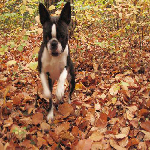

In [12]:
Image.open(PATH+fn).resize((150, 150))

In [13]:
trn_tfms, val_tfms = tfms_from_model(arch, 224) #get the training and val tfms

In [14]:
im = trn_tfms(np.array(PIL.Image.open(PATH+fn)))

In [20]:
learn.precompute = False

In [21]:
preds = learn.predict_array(im[None])

In [22]:
np.argmax(preds)

107